In [113]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 수집한 데이터

In [114]:
data = pd.read_excel('./data/samsung.xlsx')
data

,DATE,거래량,PER,PBR,기관 합계,기타법인,개인,외국인 합계,ATR,NASDAQ,S&P,CBOE,Exchange rate,futures2y,futures10y,y
0,2011-09-01,35870550,7.27,1.24,-83833734000,-8749641000,-177822918000,270406293000,880,"2,546.00","1,204.42",31.82,"1,064.40",110.28,130.61,15420
1,2011-09-02,12934100,7.26,1.23,-7185878000,2125969000,-11377060000,16436969000,1000,"2,480.30","1,173.97",33.92,"1,065.60",110.25,131.30,15380
2,2011-09-05,13874400,6.90,1.17,-975699000,-215641000,29370756000,-28179416000,580,"2,480.30","1,173.97",33.92,"1,065.60",110.25,131.30,14620
3,2011-09-06,13225250,6.86,1.17,2349662000,-1299409000,13839817000,-14890070000,1260,"2,473.80","1,165.24",37.00,"1,074.65",110.27,131.22,14540
4,2011-09-07,17575200,7.29,1.24,113232351000,1123519000,-77907268000,-36448602000,1300,"2,548.90","1,198.62",33.38,"1,069.65",110.27,130.89,15460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2456,2021-08-25,22319664,19.71,1.92,-76990474100,-8894667500,82373232300,3511909300,2000,"15,041.90","4,496.19",16.79,"1,163.87",110.25,133.63,75700
2457,2021-08-26,16671494,19.42,1.89,-55566537800,9344981600,142574757300,-96353201100,1900,"14,945.80","4,469.91",18.84,"1,170.53",110.25,133.59,74600
2458,2021-08-27,15172748,19.34,1.89,173118394100,10372274300,1510887500,-185001555900,1200,"15,129.50","4,509.37",16.39,"1,161.23",110.30,133.89,74300
2459,2021-08-30,12686999,19.42,1.89,24586418600,-2401179400,54715193800,-76900433000,2500,"15,265.90","4,528.79",16.19,"1,164.34",110.32,134.13,74600


In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2461 entries, 0 to 2460
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATE           2461 non-null   datetime64[ns]
 1   거래량            2461 non-null   int64         
 2   PER            2461 non-null   float64       
 3   PBR            2461 non-null   float64       
 4   기관 합계          2461 non-null   int64         
 5   기타법인           2461 non-null   int64         
 6   개인             2461 non-null   int64         
 7   외국인 합계         2461 non-null   int64         
 8   ATR            2461 non-null   int64         
 9   NASDAQ         2461 non-null   object        
 10  S&P            2461 non-null   object        
 11  CBOE           2461 non-null   float64       
 12  Exchange rate  2461 non-null   object        
 13  futures2y      2461 non-null   float64       
 14  futures10y     2461 non-null   float64       
 15  y              2461 n

In [116]:
# 실수형으로 변환

data['CBOE'] = data['CBOE'].astype('float')
data['futures2y'] = data['futures2y'].astype('float')
data['futures10y'] = data['futures10y'].astype('float')

In [117]:
# 실수형으로 변환(값에 ','가 포함된 경우)

data['NASDAQ'] = data['NASDAQ'].str.replace(',', '').astype(float)
data['S&P'] = data['S&P'].str.replace(',', '').astype(float)
data['Exchange rate'] = data['Exchange rate'].str.replace(',', '').astype(float)

In [118]:
scaler = MinMaxScaler()

In [119]:
scale_cols = ['거래량', 'PER', 'PBR', '기관 합계', '기타법인', '개인', '외국인 합계', 'ATR', 'NASDAQ', 'S&P', 'CBOE', 'Exchange rate', 'futures2y', 'futures10y', 'y']

In [120]:
scaled = scaler.fit_transform(data[scale_cols])
scaled

array([[0.37435295, 0.07735281, 0.07361963, ..., 0.95700935, 0.57105031,
        0.01150929],
       [0.11073659, 0.07692308, 0.06748466, ..., 0.95140187, 0.60150044,
        0.01098614],
       [0.12154377, 0.06145251, 0.03067485, ..., 0.95140187, 0.60150044,
        0.0010463 ],
       ...,
       [0.13646612, 0.59604641, 0.47239264, ..., 0.96074766, 0.71579876,
        0.78158514],
       [0.10789657, 0.59948431, 0.47239264, ..., 0.96448598, 0.72639011,
        0.78550876],
       [0.24516577, 0.6231199 , 0.50920245, ..., 0.96448598, 0.72285966,
        0.8129741 ]])

In [121]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [122]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('y', 1), df['y'], test_size=0.2, random_state=0, shuffle=False)

In [123]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1968, 14), (1968,), (493, 14), (493,))

In [124]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [125]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [126]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [127]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [128]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [129]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [130]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [131]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
61/61 [==============================] - 4s 17ms/step - loss: 0.0012 - mse: 0.0024 - val_loss: 5.7822e-04 - val_mse: 0.0012

Epoch 00001: val_loss improved from inf to 0.00058, saving model to tmp\ckeckpointer.ckpt
Epoch 2/50
61/61 [==============================] - 1s 10ms/step - loss: 1.1982e-04 - mse: 2.3965e-04 - val_loss: 6.0446e-04 - val_mse: 0.0012

Epoch 00002: val_loss did not improve from 0.00058
Epoch 3/50
61/61 [==============================] - 1s 13ms/step - loss: 1.0371e-04 - mse: 2.0742e-04 - val_loss: 5.4488e-04 - val_mse: 0.0011

Epoch 00003: val_loss improved from 0.00058 to 0.00054, saving model to tmp\ckeckpointer.ckpt
Epoch 4/50
61/61 [==============================] - 1s 13ms/step - loss: 1.0555e-04 - mse: 2.1111e-04 - val_loss: 4.6247e-04 - val_mse: 9.2494e-04

Epoch 00004: val_loss improved from 0.00054 to 0.00046, saving model to tmp\ckeckpointer.ckpt
Epoch 5/50
61/61 [==============================] - 1s 10ms/step - loss: 1.0439e-04 - mse: 2.0878e-

In [132]:
model.load_weights(filename)

In [133]:
pred = model.predict(test_data)

In [134]:
pred.shape

(473, 1)

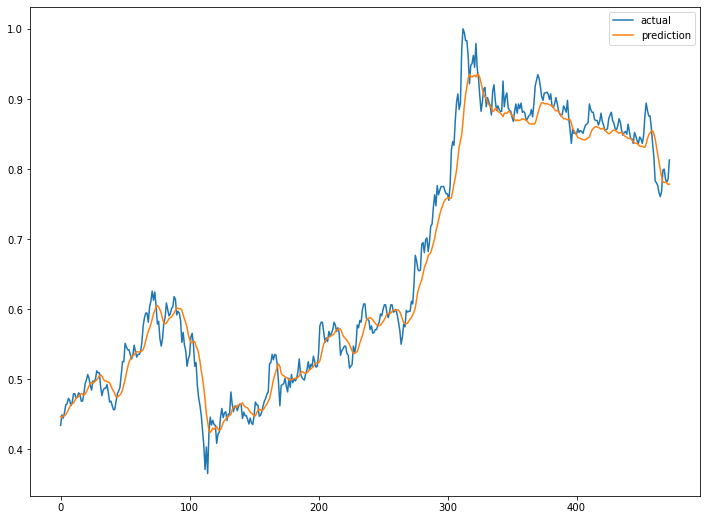

In [135]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [140]:
def RMSE(y_test, pred):
    return np.sqrt(mean_squared_error(y_test[20:], pred))

print('RMSE : ', RMSE(y_test, pred)) 

RMSE :  0.027199324644609894


In [139]:
r2_y_predict = r2_score(y_test[20:], pred)

print('R2 : ', r2_y_predict)

R2 :  0.9760756188645198
